In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(True) #opencv optimalization using GPU computing 
import warnings
warnings.filterwarnings('ignore')

In [9]:
feature_extraction_algo = 'sift'

feature_to_match = 'bf' #brute force

In [10]:
train_photo = cv2.imread('./yongzhou-small/part3/' + 'DSC03368.JPG')

train_photo = cv2.cvtColor(train_photo, cv2.COLOR_BGR2RGB)

train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread('./yongzhou-small/part3/' + 'DSC03370.JPG')

query_photo = cv2.cvtColor(query_photo, cv2.COLOR_BGR2RGB)

query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

Text(0.5, 1.0, 'Train Image (Image to transform)')

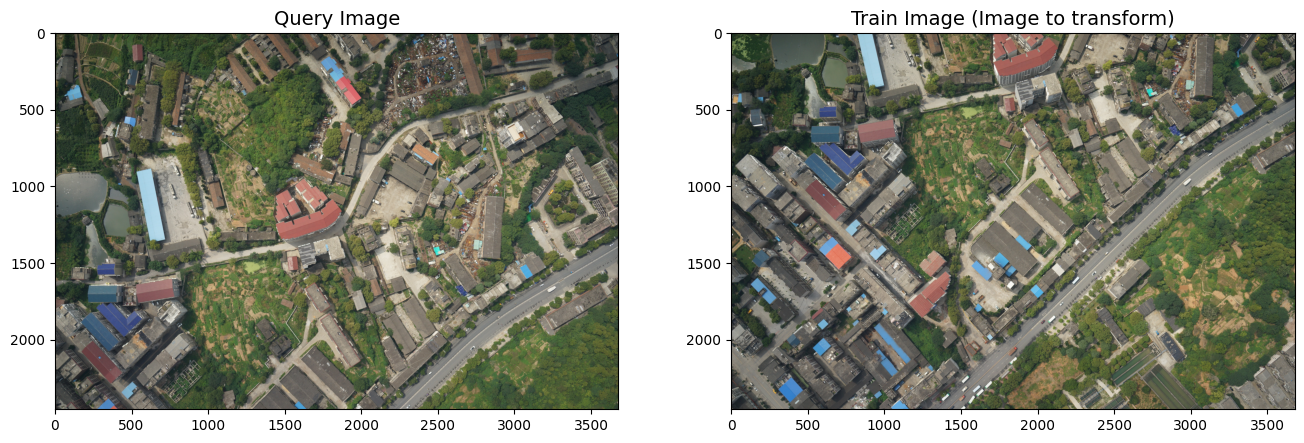

In [11]:

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(16,9))
ax1.imshow(query_photo,cmap='gray')
ax1.set_title('Query Image',fontsize=14)

ax2.imshow(train_photo,cmap='gray')
ax2.set_title('Train Image (Image to transform)',fontsize=14)

In [12]:
def select_descriptor_method(image,method = None):
    
    assert method is not None, "Please select a method from: 'sift' 'surf' 'orb' ''brisk "
    
    if method == 'sift':
        descriptor = cv2.SIFT_create()
        
    if method == 'surf':
        descriptor = cv2.SURF_create()
        
    if method == 'orb':
        descriptor = cv2.ORB_create()
        
    if method == 'brisk':
        descriptor = cv2.BRISK_create()

    (keypoints, features) = descriptor.detectAndCompute(image,None)
    
    return (keypoints, features)
        

In [13]:
keypoints_query_image, feature_query_image = select_descriptor_method(query_photo_gray,method= feature_extraction_algo)

keypoints_train_image, feature_train_image = select_descriptor_method(train_photo_gray,method= feature_extraction_algo)

#print(keypoints_query_image)


In [14]:
for keypoint in keypoints_query_image:
    x,y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id
print(x,y,size,orientation,response,octave,class_id)

3677.2197265625 661.1790771484375 3.137791395187378 273.29541015625 0.01387593150138855 6947839 -1


In [15]:
feature_query_image.shape

(65338, 128)

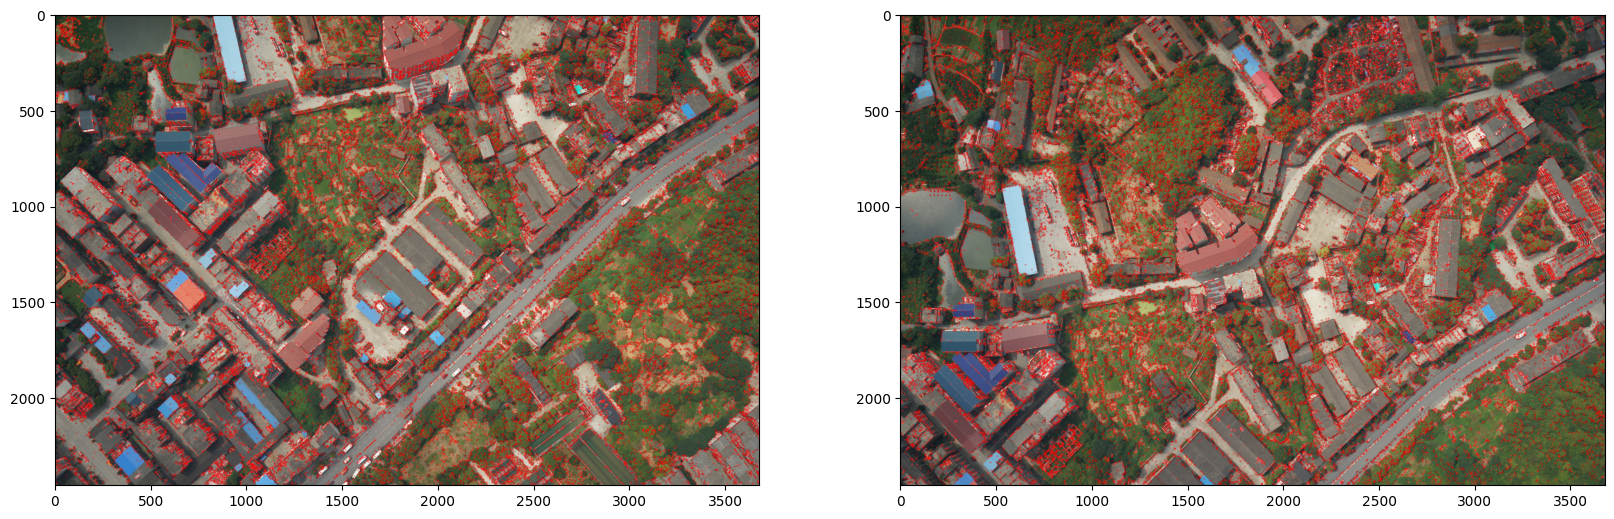

In [16]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(20,8))

ax1.imshow(cv2.drawKeypoints(train_photo,keypoints_train_image,None,color=(255,0,0)))

ax2.imshow(cv2.drawKeypoints(query_photo,keypoints_query_image,None,color=(255,0,0)))

plt.show()

In [17]:
def create_matching_object(method, crossCheck):
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck)
    if method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck)
        
    return bf

In [18]:
def key_points_matching(feature_train_image,feature_query_image, method):
    bf = create_matching_object(method, crossCheck=True)
    best_matches = bf.match(feature_train_image, feature_query_image)
    raw_matches = sorted(best_matches, key=lambda x: x.distance)
    print("Raw matches with Brute Force: ",len(raw_matches))
    return raw_matches

In [19]:
def key_points_matching_KNN(feature_train_image,feature_query_image,ratio, method):
    bf = create_matching_object(method, crossCheck=False)
    raw_matches = bf.knnMatch(feature_train_image, feature_query_image,k=2)
    print("Raw matches with KNN: ",len(raw_matches))
    knn_matches = []
    
    for m,n in raw_matches:
        if m.distance < ratio * n.distance:
            knn_matches.append(m)
    return knn_matches

Drawing matched features for:  knn
Raw matches with KNN:  61751


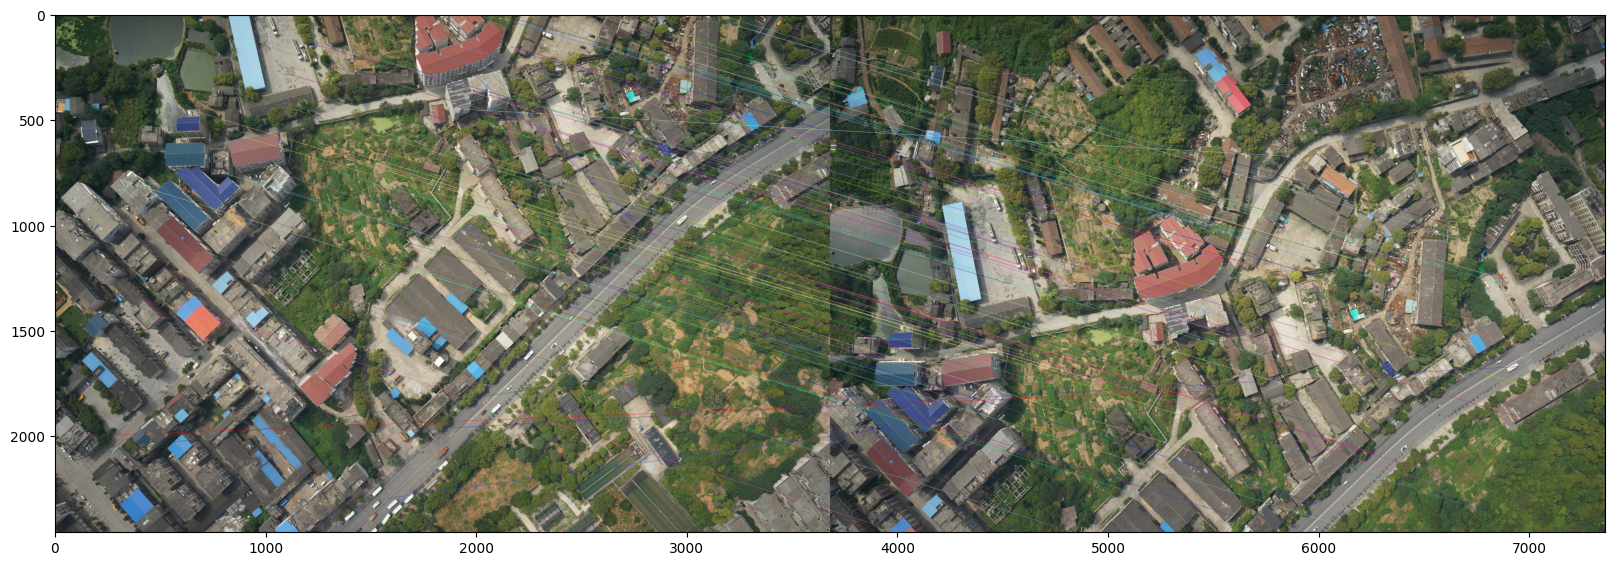

In [20]:
feature_to_match = 'knn'
print("Drawing matched features for: ", feature_to_match)

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(feature_train_image,feature_query_image,method=feature_extraction_algo)
    
    mapped_feature_image = cv2.drawMatches(train_photo,keypoints_train_image,query_photo,keypoints_query_image,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
elif feature_to_match == 'knn':
    matches = key_points_matching_KNN(feature_train_image,feature_query_image,ratio=0.75,method=feature_extraction_algo)
    
    mapped_feature_image = cv2.drawMatches(train_photo,keypoints_train_image,query_photo,keypoints_query_image,np.random.choice(matches,100),None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
plt.imshow(mapped_feature_image)

Matched keypoints between both photos

In [21]:
def homography_stitching(keypoints_train_image,keypoints_query_image,matches,reprojTreshold):
    keypoints_train_image = np.float32([keypoint.pt for keypoint in keypoints_train_image])
    keypoints_query_image = np.float32([keypoint.pt for keypoint in keypoints_query_image])
    
    if len(matches) > 4:
        points_train = np.float32([keypoints_train_image[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_image[m.trainIdx] for m in matches])

        (H,status) = cv2.findHomography(points_train,points_query,cv2.RANSAC,reprojTreshold)
        
        return (matches,H,status)
    
    else:
        return None

In [22]:
M = homography_stitching(keypoints_train_image,keypoints_query_image,matches,reprojTreshold=4)
if M is None:
    print("Error")
(matches,homography_matrix,status) = M
print(homography_matrix)

[[ 1.00772363e+00 -2.59967364e-02 -2.75803180e+02]
 [ 4.18763866e-02  1.03028070e+00  9.30612842e+02]
 [-2.20996783e-06 -1.55536816e-06  1.00000000e+00]]


In [23]:
width = query_photo.shape[1] + train_photo.shape[1]
print(width)
height = query_photo.shape[0] + train_photo.shape[0]
print(height)

7360
4912


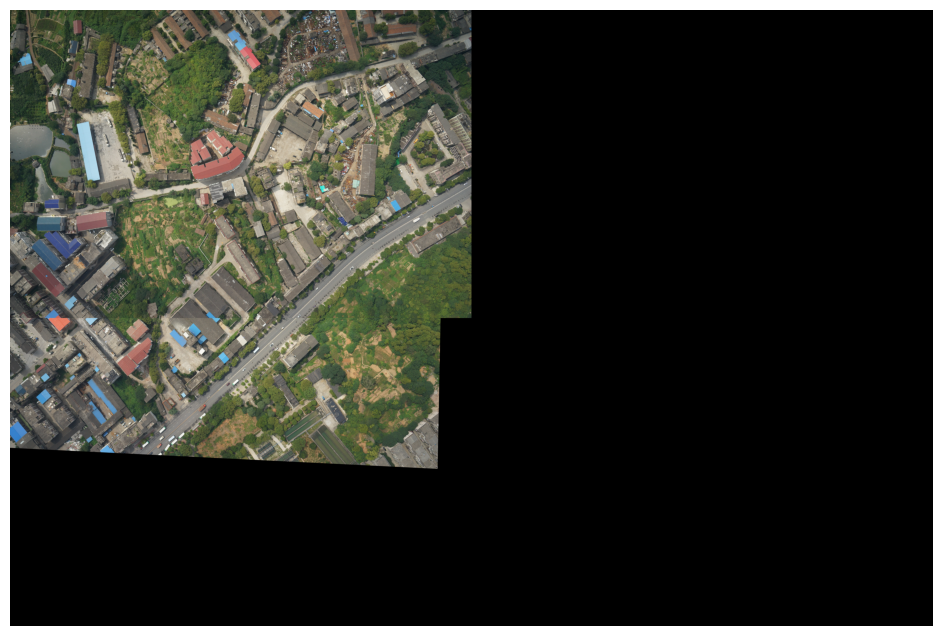

In [30]:
result = cv2.warpPerspective(train_photo,homography_matrix,(width,height))
#print(result)

result[0:query_photo.shape[0],0:query_photo.shape[1]] = query_photo

plt.figure(figsize=(20,8))
plt.axis('off')
plt.imshow(result)